<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [58]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7,activation='LeakyReLU',use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(14*14,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='sigmoid',use_bias=False))
    model.add(layers.Reshape((28,28,1)))

    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(input_img)

    x = layers.Dropout(.2)(x)

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.2)(x)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)


    x = layers.Dropout(.2)(x)

    dense_output = layers.Dense(64, activation='LeakyReLU')(x)

    x = layers.Dropout(.2)(x)

    dense_output = layers.Dense(1, activation=None)(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model



In [59]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [100]:
generator = make_generator_model()
discriminatorW = make_discriminator_model()
discriminatorU = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorW_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.000004)

In [101]:
BATCH_SIZE = 10

#@tf.function
def discriminator_lossW(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_lossW(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminatorW(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [102]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])



    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW, tf.GradientTape() as disc_tapeU:
        generated_images = generator(noise, training=True)

        real_outputW = discriminatorW(images, training=True)
        fake_outputW = discriminatorW(generated_images, training=True)

        real_outputU = discriminatorU(images, training=True)
        fake_outputU = discriminatorU(generated_images, training=True)

        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)
        disc_lossU = cross_entropy(tf.ones_like(real_outputU), real_outputU)

        gen_loss = generator_lossW(fake_outputW)
        gen_loss += cross_entropy(tf.ones_like(fake_outputU), fake_outputU)
        gp = gradient_penalty(images, generated_images)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    gradients_of_discriminatorU = disc_tapeU.gradient(disc_lossU, discriminatorU.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))
    discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminatorU, discriminatorU.trainable_variables))

    tf.print("disc_lossW",disc_lossW,'disc_lossU',disc_lossU,'gen_loss',gen_loss)

In [103]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 10
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_lossW 6.49962044 disc_lossU 0.726438165 gen_loss 0.914006829
disc_lossW 5.90742683 disc_lossU 0.725367188 gen_loss 1.10277843
disc_lossW 5.27705765 disc_lossU 0.721236169 gen_loss 1.31378031
disc_lossW 4.69356823 disc_lossU 0.708376229 gen_loss 1.57315946
disc_lossW 3.82161379 disc_lossU 0.714574695 gen_loss 1.87556267
disc_lossW 2.92020535 disc_lossU 0.72244978 gen_loss 2.15437984
disc_lossW 2.11110449 disc_lossU 0.706939757 gen_loss 2.58246684
disc_lossW 1.03695369 disc_lossU 0.71627605 gen_loss 3.05320811
disc_lossW 0.0152146816 disc_lossU 0.715115845 gen_loss 3.54584932
disc_lossW -1.27456307 disc_lossU 0.712330341 gen_loss 4.26060772
disc_lossW -2.49069476 disc_lossU 0.69756192 gen_loss 4.91810465
disc_lossW -3.13314486 disc_lossU 0.73112464 gen_loss 5.8240571
disc_lossW -4.6005888 disc_lossU 0.71171844 gen_loss 6.75211954
disc_lossW -5.97942686 disc_lossU 0.699934125 gen_loss 7.90419388
disc_lossW -7.1408 disc_lossU 0.705795 gen_loss 9.33201
disc_lossW -7.88134193 disc_lossU

1/1 [==============================] - 0s 19ms/step


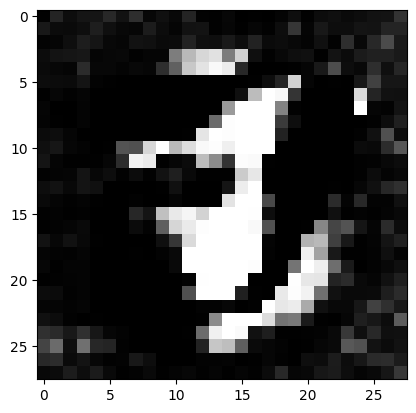

In [97]:
noise = tf.random.normal(shape=(1,100))
test = generator.predict(noise)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(np.min(x_train2))